Uber data-set for bookings done in a month in one city [https://drive.google.com/file/d/1Kv-htgutdstCIrzNqaj3ZlJrJ5MjZlfP/view?usp=sharing]

Download excel data from the link

Identify trends from the dataset

Visualization or algorithm to prune the data of incorrect tuples [if they are there]

Analyze if the data set can be used for supervised or unsupervised learning

Model to predict number of bookings on a particular day and location

In [1]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6
!pip install basemap
!pip install mplleaflet
!pip install git+https://github.com/python-visualization/folium
!pip install joblib

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 0s (218 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 145480 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Setting up libgeos-dev (3.6.2-1b

     |████████████████████████████████| 2.8MB 26.8MB/s 
  Created wheel for pyproj: filename=pyproj-1.9.6-cp36-cp36m-linux_x86_64.whl size=3702087 sha256=7c276ed658575fbbbd639ebb9b0d7595a59f7a795a4d024066e8ff595b84a1ef
  Stored in directory: /root/.cache/pip/wheels/02/cd/b1/a2d6430f74c7a778a43d62f78bec109ca69c732dc9b929142a
Successfully built pyproj
  Found existing installation: pyproj 3.0.0.post1
    Uninstalling pyproj-3.0.0.post1:
      Successfully uninstalled pyproj-3.0.0.post1
  Created wheel for mplleaflet: filename=mplleaflet-0.0.5-cp36-none-any.whl size=28555 sha256=509575b8633bb3ce35322999d6dc6508cbae7021136cc62af025dd1c79607d7c
  Stored in directory: /root/.cache/pip/wheels/bf/fd/0b/0513de62c339c4a56e2234aa42a5d06e6660a4446fdae7b796
Successfully built mplleaflet
  Cloning https://github.com/python-visualization/folium to /tmp/pip-req-build-wgftvzyx
  Running command git clone -q https://github.com/python-visualization/folium /tmp/pip-req-build-wgftvzyx
  Created wheel for f

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from mpl_toolkits.basemap import Basemap
from matplotlib import cm #Colormap
import mplleaflet as mpl
import folium

from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

%matplotlib inline


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

import pandas as pd
uber_data= pd.read_csv (r'/content/drive/MyDrive/Assignement_Citility/uber-raw-data-jul14.csv')
print(uber_data.info())
uber_data.head(5)
uber_data.describe(include = 'all',datetime_is_numeric=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796121 entries, 0 to 796120
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date/Time  796121 non-null  object 
 1   Lat        796121 non-null  float64
 2   Lon        796121 non-null  float64
 3   Base       796121 non-null  object 
dtypes: float64(2), object(2)
memory usage: 24.3+ MB
None


,Date/Time,Lat,Lon,Base
count,796121,796121.000000,796121.000000,796121
unique,44286,NaN,NaN,5
top,7/15/2014 19:30:00,NaN,NaN,B02617
freq,79,NaN,NaN,310160
mean,NaN,40.739141,-73.972353,NaN
std,NaN,0.040551,0.058660,NaN
min,NaN,39.721400,-74.826000,NaN
25%,NaN,40.720900,-73.996100,NaN
50%,NaN,40.742500,-73.983200,NaN
75%,NaN,40.760800,-73.965100,NaN


In [5]:
uber_data['Date/Time'] = pd.to_datetime(uber_data['Date/Time'], format="%m/%d/%Y %H:%M:%S")

In [6]:
def dateTimeExpansion(df):    
  df['Weekday'] = df['Date/Time'].dt.day_name()
  df['Day'] = df['Date/Time'].dt.day
  df['Hour'] = df['Date/Time'].dt.hour
  df['Minute'] = df['Date/Time'].dt.minute
  return df
uber_data=dateTimeExpansion(uber_data)
from pandas.api.types import CategoricalDtype
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekdays_sort = CategoricalDtype(categories=weekdays, ordered=True)
uber_data['Weekday'] = uber_data['Weekday'].astype(weekdays_sort)
uber_data.head(5)

,Date/Time,Lat,Lon,Base,Weekday,Day,Hour,Minute
0,2014-07-01 00:03:00,40.7586,-73.9706,B02512,Tuesday,1,0,3
1,2014-07-01 00:05:00,40.7605,-73.9994,B02512,Tuesday,1,0,5
2,2014-07-01 00:06:00,40.7320,-73.9999,B02512,Tuesday,1,0,6
3,2014-07-01 00:09:00,40.7635,-73.9793,B02512,Tuesday,1,0,9
4,2014-07-01 00:20:00,40.7204,-74.0047,B02512,Tuesday,1,0,20


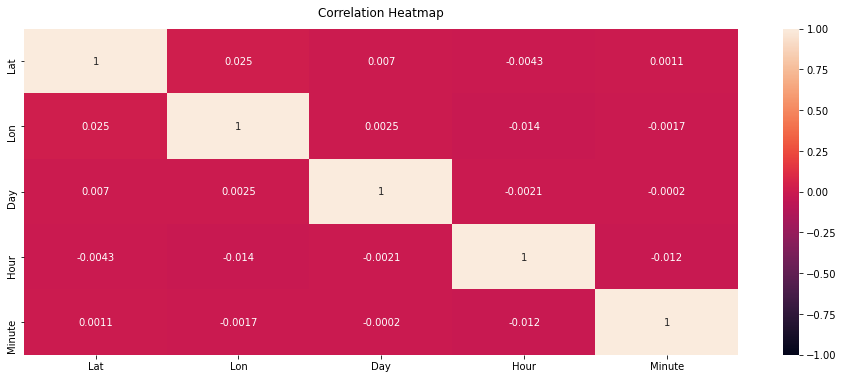

In [7]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(uber_data.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [8]:
#checking for null values
uber_data.isnull().sum()

Date/Time    0
Lat          0
Lon          0
Base         0
Weekday      0
Day          0
Hour         0
Minute       0
dtype: int64

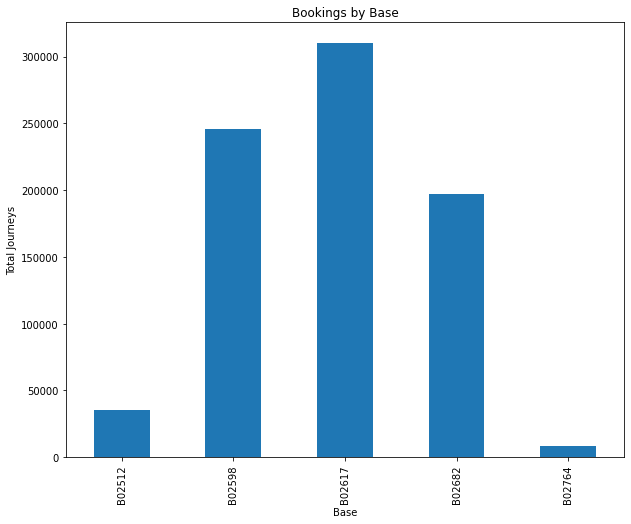

In [9]:
uber_base= uber_data.pivot_table(index=['Base'],
                                  aggfunc='size')
uber_base.plot(kind='bar', figsize=( 10,8))
plt.ylabel('Total Journeys')
plt.title('Bookings by Base');

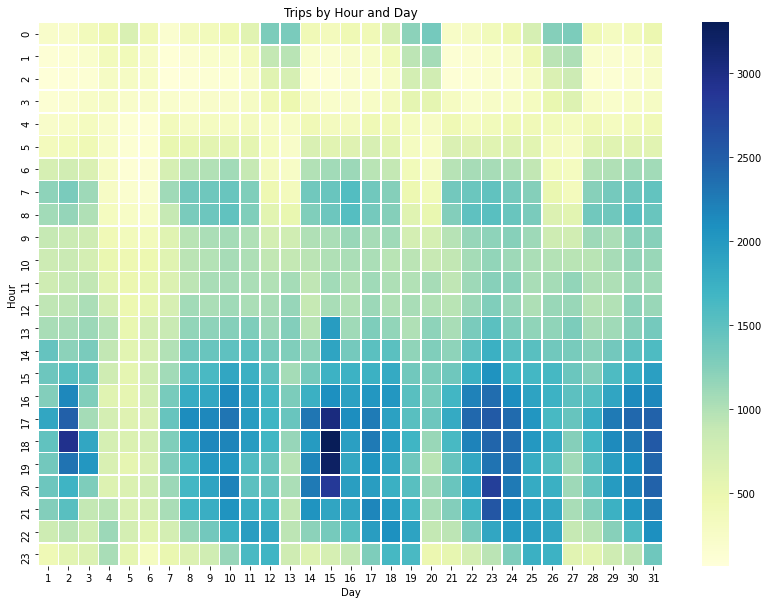

In [10]:
uber_hourday = uber_data.pivot_table(index=['Hour'],columns=['Day'],
                                  values='Base',
                                  aggfunc='count')
#print(uber_hourday)
fig, ax = plt.subplots(figsize=(14,10))  
ax = sns.heatmap(uber_hourday, cmap=cm.YlGnBu, linewidth = .5,ax=ax)
ax.set(title="Trips by Hour and Day");

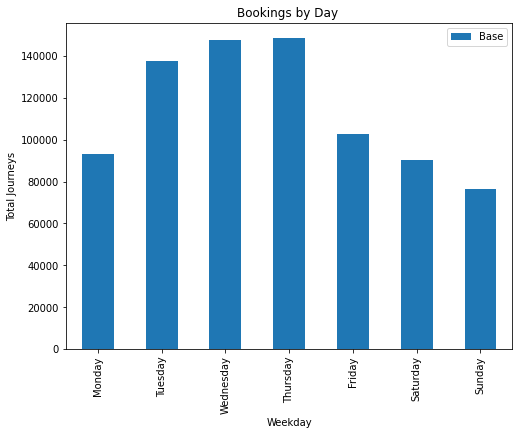

In [11]:
uber_weekdays = uber_data.pivot_table(index=['Weekday'],
                                  values='Base',
                                  aggfunc='count')
uber_weekdays.plot(kind='bar', figsize=(8,6))
plt.ylabel('Total Journeys')
plt.title('Bookings by Day ');

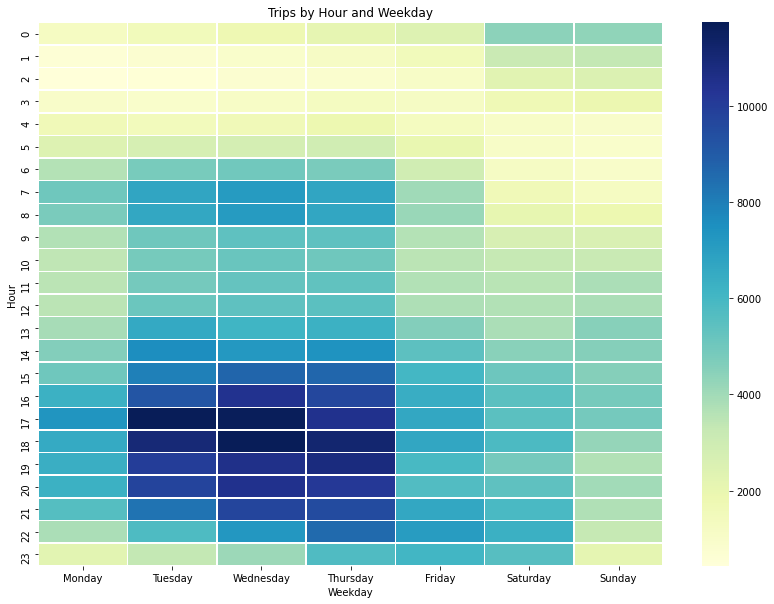

In [12]:
uber_hourday = uber_data.pivot_table(index=['Hour'],columns=['Weekday'],
                                  values='Base',
                                  aggfunc='count')
fig, ax = plt.subplots(figsize=(14,10))  
ax = sns.heatmap(uber_hourday, cmap=cm.YlGnBu, linewidth = .5,ax=ax)
ax.set(title="Trips by Hour and Weekday");



In [13]:
hourly_ride_data = uber_data.pivot_table(index=['Weekday','Day','Hour'],
                                  values='Base',
                                  aggfunc='count')
hourly_ride_data = hourly_ride_data.reset_index()
hourly_ride_data = hourly_ride_data.rename(columns = {'Base':'ride_count'})
hourly_ride_data = hourly_ride_data.sort_index()


weekly_avg = hourly_ride_data.pivot_table(index=['Weekday','Hour'],
                                  values='ride_count',
                                  aggfunc='mean')
weekly_avg = weekly_avg.reset_index()
weekly_avg= weekly_avg.rename(columns = {'ride_count':'avg_ride'})
weekly_avg = weekly_avg.sort_index()
weekly_avg.head()

,Weekday,Hour,avg_ride
0,Monday,0,315.00
1,Monday,1,153.25
2,Monday,2,109.75
3,Monday,3,254.75
4,Monday,4,403.75


Text(0.5, 0, 'Hour')

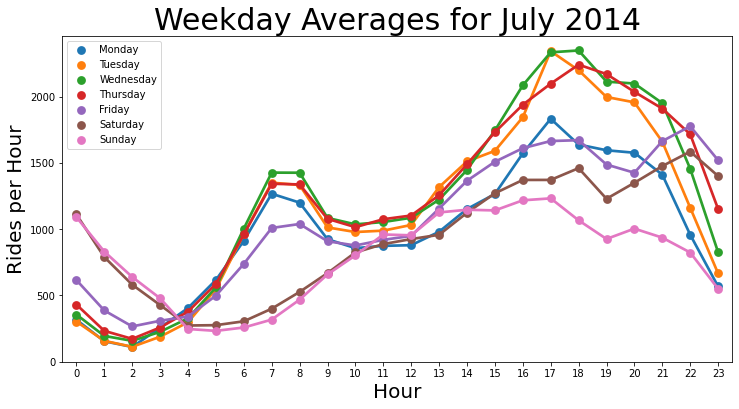

In [14]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

## plot data
sns.pointplot(data = weekly_avg,ax=ax, x='Hour',y='avg_ride',hue='Weekday')

## clean up the legend
l = ax.legend()
l.set_title('')

## format plot labels
ax.set_title('Weekday Averages for July 2014', fontsize=30)
ax.set_ylabel('Rides per Hour', fontsize=20)
ax.set_xlabel('Hour', fontsize=20)

In [15]:
lat_lon_freq=uber_data.value_counts(["Lat", "Lon"]).reset_index(name="Count")
lat_lon_freq.head()

,Lat,Lon,Count
0,40.6448,-73.7819,638
1,40.6448,-73.7820,553
2,40.6448,-73.7818,497
3,40.6447,-73.7821,396
4,40.7741,-73.8726,369


1) Most people leave for work on weekdays between 6:00 and 9.00.
2) Most people leave for home on weekdays between 17:00 and 18:59.
3) People stay out pretty late on Friday and Saturday nights leading to brighter than usual spots between 21:00 to 23:59 on Friday, 00:00 to 02:59 and 21:00 to 23:59 on Saturday and 00:00
to 02:59 on Sunday.
4) Most people start their weekends later than usual

On weekdays from 7-9 am, trips spike on Monday through Friday. This likely represents people’s morning commute to work.
As evening approaches, the city comes alive. From 5-10 pm, we see another set of concentrated trips. People leave work and head home or go out for dinner and drinks.
On weekends, the pattern is completely different. Starting Friday night, people go out later; this is reflected in the brightness from 12-2 am on Saturday. Several hours later on Saturday morning, from 7-10 am, the number of Uber trips is considerably smaller as people sleep in. The same pattern picks up on Saturday night from 12-2 am, and then falls to a lull on Sunday morning as well (4-9 am), which extends a few hours beyond the 1-5 am trip dead zone on weekdays.

Unfortunatly we have not been able to find any factual information to explain the pulse. A successful marketing strategy can be assumed to be in place that days. So as the analysis go on we consider that day an outliner.

Weekdays see a skewed bimodal distribution, with a smaller peak during the morning commute and a larger peak beginning at the close of business and continuing through evening social hours. Weekends do not experience a morning rush, but rise steadily throughout the day before diverging in the early evening. Thursday shows the largest evening volume. However, while Friday and Saturday nights plateau at lower levels than Thursday, the carryover into the early morning party hours (Sat/Sun morning 0-2 AM) is much more significant.


In [16]:
%matplotlib inline
from folium.plugins import HeatMap
points = (lat_lon_freq.Lat,lat_lon_freq.Lon) 		
coordinates =[]
# Setting lat and long 
lat = points[0]
long = points[1]
hmap = folium.Map(location=[40.6448, -73.7819])
for la,lo in zip(lat,long):
    coordinates.append([la,lo])
HeatMap(coordinates).add_to(hmap)
hmap.save("/content/drive/MyDrive/Assignement_Citility/hmap.html")
hmap


Output hidden; open in https://colab.research.google.com to view.

In [17]:
def get_hot_spots(max_distance,min_cars,ride_data):
    
    ## get coordinates from ride data
    coords = ride_data[['Lat', 'Lon']].to_numpy()
    
    ## calculate epsilon parameter using the user defined distance
    kms_per_radian = 6371.0088
    epsilon = max_distance / kms_per_radian
    
    ## perform clustering
    db = DBSCAN(eps=epsilon, min_samples=min_cars,
                algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    ## group the clusters
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
    
    ## report
    print('Number of clusters: {}'.format(num_clusters))
    
    ## initialize lists for hot spots
    lat = []
    lon = []
    num_members = []
    
    ## loop through clusters and get centroids, number of members
    for ii in range(len(clusters)):
           ## filter empty clusters
        if clusters[ii].any():

            ## get centroid and magnitude of cluster
            lat.append(MultiPoint(clusters[ii]).centroid.x)
            lon.append(MultiPoint(clusters[ii]).centroid.y)
            num_members.append(len(clusters[ii]))
            
    hot_spots = [lon,lat,num_members]
    
    return hot_spots

In [18]:
## maximum distance between two cluster members in kilometers
max_distance = 0.05

## minimum number of cluster members
min_pickups = 200

## call the get_hot_spots function
hot_spots = get_hot_spots(max_distance ,min_pickups, uber_data)

Number of clusters: 190


In [19]:
## make the figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)


color_scale = np.log(hot_spots[2])
# color_scale = hot_spots[2]


plt.scatter(hot_spots[0], hot_spots[1],s=80,c=color_scale,cmap=cm.cool)

mpl.display()  

In [20]:
from datetime import datetime
#Take only the first week of data
uber_data["Date_Hour"] = uber_data["Date/Time"].apply(lambda x: x.replace(microsecond=0,second=0,minute=0))
map_data = uber_data.copy()
#Randomly sample 1/3 the values in each group
map_data["Weight"] = .1
map_data = map_data.groupby('Date_Hour').apply(lambda x: x[["Lat", "Lon", "Weight"]].sample(int(len(x)/3)).values.tolist())
#Get the index
date_hour_index = [x.strftime("%m/%d/%Y, %H:%M:%S") for x in map_data.index]

#Get the data in list form (each element of this bigger list will be a list of lists with lat/lon/weight)
#Each element of the bigger list is a for a date/hour combo
date_hour_data = map_data.to_list()

In [21]:
from folium.plugins import HeatMapWithTime
uber_map = folium.Map(location=[40.6448, -73.7819])
#A heatmap with time can now be out together
hm = HeatMapWithTime(date_hour_data, index=date_hour_index)
hm.add_to(uber_map)
hm.save("/content/drive/MyDrive/Assignement_Citility/hmap_time.html")
uber_map

Output hidden; open in https://colab.research.google.com to view.

Now that the visualization is done, let's apply some models on our data and assess their performances

In [22]:
import datetime as dt
model_data=uber_data.copy()
model_data['Date'] = model_data['Date_Hour'].dt.date
model_data=model_data.drop(labels="Date_Hour",axis=1)
model_data=model_data.value_counts(["Lat", "Lon","Date"]).reset_index(name="Rides")
values=model_data.values
model_data['Date']=model_data['Date'].map(dt.datetime.toordinal)
print(model_data.head(5))

       Lat      Lon    Date  Rides
0  40.6448 -73.7820  735434     32
1  40.6448 -73.7819  735434     32
2  40.6448 -73.7820  735420     31
3  40.6448 -73.7819  735430     30
4  40.6448 -73.7819  735439     30


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

X = model_data.loc[:, model_data.columns != 'Rides']
y = model_data.loc[:, model_data.columns == 'Rides']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

y_train= y_train.values.ravel()
y_test= y_test.values.ravel()

In [24]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=1000,criterion='mse',random_state=1)  
rf_model.fit(X_train,y_train)
y_pred_rf = rf_model.predict(X_test)

rmse_rf = np.sqrt(mse(y_test, y_pred_rf)) 

SS_Residual = sum((y_test-y_pred_rf)**2)       
SS_Total = sum((y_test-np.mean(y_test))**2)     
r_squared_rf = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared_rf = 1 - (1-r_squared_rf)*(len(y_test)-1)/(len(y_test)-X_train.shape[1]-1)

print("RMSE RF : % f" %(rmse_rf))
print("r_squared : % f" %(r_squared_rf)) 
print("adjusted_r_squared : % f" %(adjusted_r_squared_rf)) 

RMSE RF :  0.479960
r_squared :  0.381276
adjusted_r_squared :  0.381262


In [25]:
import xgboost as xgb 

xgb_model =xgb.XGBRegressor(objective ='reg:squarederror',n_estimators = 1000, seed = 1,max_depth=5,min_child_weight = 1,learning_rate='0.1',nthread=4, subsample=0.8, colsample_bytree = 0.8, gamma = 0 , eval_metric='rmse',random_state=1) 
xgb_model.fit(pd.DataFrame(X_train,columns=X.columns) , y_train)
y_pred_xgb = xgb_model.predict(X_test)

rmse_xgb = np.sqrt(mse(y_test, y_pred_xgb)) 

SS_Residual = sum((y_test-y_pred_xgb)**2)       
SS_Total = sum((y_test-np.mean(y_test))**2)     
r_squared_xgb = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared_xgb = 1 - (1-r_squared_xgb)*(len(y_test)-1)/(len(y_test)-X_train.shape[1]-1)

print("RMSE XGB : % f" %(rmse_xgb)) 
print("r_squared : % f" %(r_squared_xgb)) 
print("adjusted_r_squared : % f" %(adjusted_r_squared_xgb)) 

RMSE XGB :  0.457776
r_squared :  0.437149
adjusted_r_squared :  0.437137


In [26]:
Lat=float(input("Enter Latitude"))
Lon=float(input("Enter Longitude"))
Date=input("Enter Date")
Date=datetime.strptime(Date, '%Y-%m-%d').date()
Date=Date.toordinal()
x_data= [[Lat,Lon,Date]]
y1 = rf_model.predict(x_data)
y2=xgb_model.predict(pd.DataFrame(x_data,columns=X.columns))
print(y1)
print(y2)


Enter Latitude40.6448
Enter Longitude -73.7820
Enter Date2014-08-01
[14.973]
[16.12818]


In [38]:
%cd /content/drive/MyDrive/Assignement_Citility/

/content/drive/MyDrive/Assignement_Citility


In [39]:
import joblib as jl 

xgb_model_save = "xgb_model_save.pkl"  
jl.dump(xgb_model, xgb_model_save )

rf_model_save = "rf_model_save.pkl"  
jl.dump(rf_model, rf_model_save )

['rf_model_save.pkl']

In [28]:
ssss